<a href="https://colab.research.google.com/github/Vilagamer999/SneakGAN/blob/main/files/SneakGAN%20generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
#@title Install libraries and download model {display-mode: "form"}
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch/
!pip install ninja

#@title # Useful utility functions...
%cd /content/stylegan2-ada-pytorch/
import os
import re
from typing import List, Optional

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from io import BytesIO
import legacy

import argparse
import numpy as np
import PIL.Image
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import os
import pickle
from google.colab import files


from IPython.display import clear_output 

def generate_images(zs, truncation_psi):
    # Gs_kwargs = dnnlib.EasyDict()
    # Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    # Gs_kwargs.randomize_noise = False
    # if not isinstance(truncation_psi, list):
    #     truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    # for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
    #     Gs_kwargs.truncation_psi = truncation_psi[z_idx]
    #     noise_rnd = np.random.RandomState(1) # fix noise
    #     tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    #     images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
    #     imgs.append(PIL.Image.fromarray(images[0], 'RGB'))

    # for seed_idx, seed in enumerate(seeds):
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        # print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
        # img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = G(z, None, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB'))
        # PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        # z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True, save=False, id=None):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  #####
  if save:
      PIL.Image.fromarray(a).save(str(id[0]) + '.png', format)
  ####
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

%cd /content/

url = 'https://drive.google.com/file/d/1JIQG-q29At0I9SQ7UTdmsmgxf83zG5Kz/view?usp=sharing'


os.environ['ID']= url.split('/')[-2]

!gdown --id $ID -O network.pkl

%cd /content/stylegan2-ada-pytorch/

outdir = '/content/out/'
seeds = [1,2,3]
truncation_psi = 0.7
noise_mode = 'const' # ['const', 'random', 'none']
network_pkl = '/content/network.pkl'

print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
clear_output()

print('All done!')

Done!


# Generating images and videos



[223768667]


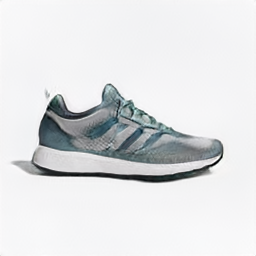

In [11]:
#@title Generate a single image{display-mode: "form"}
#@markdown Use -1 for random seed or type a specific seed (from 0 up to 2^32-1):

rand = -1 #@param {type: "number"}

if rand == -1:
    rand = np.random.randint(4294967295, size=1)
else:
    rand = [rand]
print(rand)

imshow(generate_images_from_seeds(rand, truncation_psi=0.7)[0])

[422529249, 3632003302, 3569386047, 4260247253, 4050413557, 3241339191, 2300329864, 1037564181]
[3638565798, 2056451602, 4211765283, 4012293034, 2881927627, 1641665880, 2669966433, 1602755153]
[477560039, 3809224830, 3662139750, 3222766631, 3409384420, 336676387, 3634877548, 2403539863]



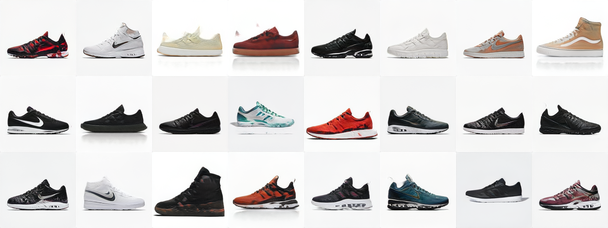

In [9]:
#@title Generate grid of images{display-mode: "form"}

size =  24#@param {type: "number"}

seeds = np.random.randint((2**32 - 1), size=size)

rows =  3#@param {type: "number"}
image_size = 0.3 #@param {type: "number"}


# np.random.shuffle(seeds)


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

for _ in chunks(list(seeds), ceil(size/rows)):
  print(_)
print()
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.7), image_size , rows))

In [5]:
#@title Generate interpolation video  {display-mode: "form"}

video_output_path = '/content/out/'
video_name = 'interpolation_movie.mp4'
movie_name = video_output_path + video_name



try:
  os.mkdir(video_output_path)
except:
  pass

size = 10 #@param {type: "number"}
seeds = list(np.random.randint((2**32) - 1, size=size))


print(seeds)
seeds = seeds + [seeds[0]]
zs = generate_zs_from_seeds(seeds)

number_of_steps =  50#@param {type: "number"}
trunc_psi = 0.7
imgs = generate_images(interpolate(zs,number_of_steps), trunc_psi)

with imageio.get_writer(movie_name, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

download_video = False #@param {type:"boolean"}
if download_video:
    files.download(movie_name) 



[737738683, 2285636716, 839819115, 828715113, 66656120, 3189920201, 1700933270, 3674347328, 2763409045, 598662252]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
#@title View video in colab {display-mode: "form"}

from IPython.display import HTML
from base64 import b64encode
mp4 = open(movie_name,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)